In [1]:
import torch
import torchvision
from torch import nn
import numpy as np
from torch import optim
from torchvision import models,transforms
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

vgg = models.vgg16(pretrained=True)

''' 
vgg contains :
    features: convolutional part for feature extraction
    avg_pool: average pooling
    classifier: dense layers for classification
'''
# we only want to visualise convolutional layers
vgg = vgg.features
vgg.cuda().eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:14<00:00, 37849882.01it/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

## Download and normalize the image

--2019-06-25 19:46:57--  https://turntable.kagiso.io/images/Screen_Shot_2019-05-20_at_7.49.14_AM.width-800.png
Resolving turntable.kagiso.io (turntable.kagiso.io)... 104.25.121.109, 104.25.122.109, 2606:4700:20::6819:7a6d, ...
Connecting to turntable.kagiso.io (turntable.kagiso.io)|104.25.121.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580207 (567K) [image/png]
Saving to: ‘Screen_Shot_2019-05-20_at_7.49.14_AM.width-800.png’

Screen_Shot_2019-05 100%[===================>] 566.61K  --.-KB/s    in 0.03s   

2019-06-25 19:46:58 (17.0 MB/s) - ‘Screen_Shot_2019-05-20_at_7.49.14_AM.width-800.png’ saved [580207/580207]



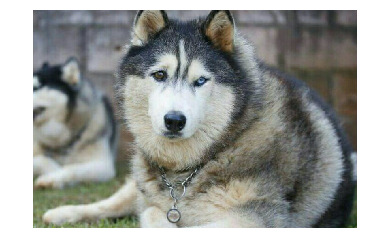

In [2]:
!wget https://turntable.kagiso.io/images/Screen_Shot_2019-05-20_at_7.49.14_AM.width-800.png
    
image = Image.open("Screen_Shot_2019-05-20_at_7.49.14_AM.width-800.png")
plt.axis('off')
plt.imshow(image)
plt.show()

transforms = transforms.Compose([transforms.Resize(512),
                                     transforms.CenterCrop(512),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485 , 0.456 , 0.406], [0.229 , 0.224 , 0.225])
                                    ])
image = transforms(image)
# add the batch axis
image = image.unsqueeze(0).cuda()

## Naming the Layers

In [3]:
def name_layers(model):
    net = nn.Sequential()
    sub_counter = 0
    main_counter = 1
    
    for layer in model.children():
        
        # if the current layer is conv2d,
        # increment the subcounter
        if isinstance(layer , nn.Conv2d):
            sub_counter += 1
            name = 'conv {}_{}'.format(main_counter,sub_counter)
            
        # relu layers are assumed to belong to 
        # the previous conv layer, so no need to
        # increment the subcounter
        if isinstance(layer , nn.ReLU):
            name = 'relu {}_{}'.format(main_counter,sub_counter)
            
        # if the current layer is maxpool,
        # current block is over. So, increment
        # the main counter and reset the subcounter
        if isinstance(layer , nn.MaxPool2d):
            name = 'maxpool {}'.format(main_counter)
            main_counter += 1 
            sub_counter = 0
            
        net.add_module(name , layer)
    return net

net = name_layers(vgg)
net.cuda()

Sequential(
  (conv 1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu 1_1): ReLU(inplace)
  (conv 1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu 1_2): ReLU(inplace)
  (maxpool 1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv 2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu 2_1): ReLU(inplace)
  (conv 2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu 2_2): ReLU(inplace)
  (maxpool 2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv 3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu 3_1): ReLU(inplace)
  (conv 3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu 3_2): ReLU(inplace)
  (conv 3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu 3_3): ReLU(inplace)
  (maxpool 3): MaxPool2d(kernel_size=2, stri

## Function to plot the output of any layer

In [0]:
def plot_activations(image):
    
    # Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.
    image = image.cpu().detach().squeeze(0).numpy()
    image = image.transpose(1,2,0)
    image.clip(0,1)
    
    fig = plt.figure(figsize=(12,6))
    for i in range(32):
        fig.subplots_adjust(hspace=0.1, wspace=0.1) #height , width
        plt.subplot(4, 8, i+1)
        plt.imshow(image[:,:,i])
        plt.axis('off')

    plt.show()

## Plot

In [5]:
x = image
for name, layer in net.named_children():
    x = layer(x)
    print(name)
    plot_activations(x)

Output hidden; open in https://colab.research.google.com to view.